In [1]:
from utils.flax_utils import restore_agent
import glob, tqdm, wandb, os, json, random, time, jax
from absl import app, flags
from ml_collections import config_flags
from utils.flax_utils import save_agent, load_example_batch
from agents import agents
import numpy as np
import json
import ml_collections
from envs import droid_utils


# if 'CUDA_VISIBLE_DEVICES' in os.environ:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['EGL_DEVICE_ID'] = os.environ['CUDA_VISIBLE_DEVICES']
os.environ['MUJOCO_EGL_DEVICE_ID'] = os.environ['CUDA_VISIBLE_DEVICES']

def load_config_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # 딕셔너리를 ConfigDict로 변환 (점 표기법 사용 가능 및 Type safety)
    config = ml_collections.ConfigDict(data)
    return config

FLAGS = flags.FLAGS

checkpoint_path = '/home/jellyho/Offline/debs/exp/MFQ_DROID/meanflowq:debug/droid_pnp_carrot/MFLQL_long_reward_v1'
checkpoint_step = 10000
dataset_name = 'droid_pnp_carrot'
dataset_path = '/data5/jellyho/droid_rl/'

def get_param_count(agent):
    """Calculate and return the number of parameters in the network."""
    params = agent.network.params
    if hasattr(params, 'unfreeze'):
        params = params.unfreeze()
    
    param_counts = {}
    
    # Calculate module-wise parameter counts
    for module_name, module_params in params.items():
        module_leaves = jax.tree_util.tree_leaves(module_params)
        param_counts[module_name] = sum(param.size for param in module_leaves)
    
    # Calculate total parameters
    all_leaves = jax.tree_util.tree_leaves(params)
    param_counts['total'] = sum(param.size for param in all_leaves)
    
    return param_counts

def print_param_stats(agent):
    """Print network parameter statistics."""
    param_counts = get_param_count(agent)
    
    print("Network Parameter Statistics:")
    print("-" * 50)
    
    # Print module-wise parameter counts
    for module_name, count in param_counts.items():
        if module_name != 'total':
            print(f"{module_name}: {count:,} parameters ({count * 4 / (1024**2):.2f} MB)")
    
    # Print total parameter count
    total = param_counts['total']
    print("-" * 50)
    print(f"Total parameters: {total:,} ({total * 4 / (1024**2):.2f} MB)")


path = checkpoint_path
step = checkpoint_step
flag_config = load_config_from_json(f'{path}/flags.json')
config = flag_config.agent
config["horizon_length"] = flag_config.horizon_length
ckpt_name = path.split("/")[-1]
log_dir = "eval_logs/" + ckpt_name

def print_batch_shapes(batch, prefix=""):
    for k, v in batch.items():
        try:
            print(f"{prefix}{k}: {v.shape}")
        except (AttributeError, TypeError):
            if isinstance(v, dict):
                print_batch_shapes(v, prefix=f"{prefix}{k}.")
            else:
                pass
example_batch = load_example_batch(path)
print_batch_shapes(example_batch)

agent_class = agents[config['agent_name']]
agent = agent_class.create(
    100,
    example_batch['observations'],
    example_batch['actions'],
    config,
)
agent = restore_agent(agent, path, step)

droid_path = os.path.join(dataset_path, dataset_name)
dataset = droid_utils.load_droid_dataset(droid_path, include_failure=False)

/home/jellyho/miniconda3/envs/debs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[System] Example batch loaded from /home/jellyho/Offline/debs/exp/MFQ_DROID/meanflowq:debug/droid_pnp_carrot/MFLQL_long_reward_v1/example_batch.pkl
actions: (256, 5, 7)
masks: (256,)
next_observations.image: (256, 224, 224, 6)
next_observations.state: (256, 7)
observations.image: (256, 224, 224, 6)
observations.state: (256, 7)
rewards: (256,)
terminals: (256,)
valid: (256,)
Restored from /home/jellyho/Offline/debs/exp/MFQ_DROID/meanflowq:debug/droid_pnp_carrot/MFLQL_long_reward_v1/params_10000.pkl
Loading 50 success and 0 failure trajectories...


Reading HDF5: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Dataset creation complete!
Total transitions: 4889


In [2]:
from utils.datasets import Dataset, ReplayBuffer
dataset = Dataset.create(**dataset)

In [3]:
for _ in range(100):
    sample = dataset.sample(256)
    print(sample['masks'].sum())

254.0
251.0
254.0
254.0
250.0
253.0
255.0
253.0
253.0
253.0
254.0
254.0
253.0
251.0
253.0
255.0
253.0
248.0
254.0
252.0
254.0
255.0
254.0
253.0
252.0
254.0
254.0
254.0
252.0
255.0
251.0
256.0
254.0
254.0
255.0
253.0
254.0
255.0
254.0
254.0
252.0
255.0
253.0
256.0
254.0
254.0
254.0
255.0
250.0
251.0
251.0
253.0
254.0
253.0
252.0
255.0
252.0
256.0
254.0
255.0
252.0
255.0
256.0
254.0
255.0
255.0
253.0
253.0
254.0
254.0
255.0
252.0
255.0
251.0
255.0
255.0
254.0
256.0
252.0
255.0
251.0
253.0
250.0
254.0
252.0
253.0
254.0
254.0
255.0
254.0
252.0
253.0
254.0
255.0
254.0
256.0
255.0
255.0
252.0
253.0


In [70]:
terminal_indices = np.where(dataset['terminals'] == 1)[0]
start_indices = np.concatenate([[0], terminal_indices[:-1] + 1])

In [71]:
terminal_indices

array([ 118,  224,  320,  437,  528,  645,  769,  877,  984, 1097, 1192,
       1285, 1408, 1497, 1608, 1732, 1849, 1946, 2041, 2146, 2240, 2343,
       2438, 2534, 2627, 2722, 2821, 2932, 3016, 3098, 3177, 3259, 3343,
       3423, 3546, 3648, 3742, 3822, 3931, 4014, 4087, 4170, 4292, 4361,
       4418, 4489, 4563, 4681, 4788, 4888])

In [72]:
start_indices

array([   0,  119,  225,  321,  438,  529,  646,  770,  878,  985, 1098,
       1193, 1286, 1409, 1498, 1609, 1733, 1850, 1947, 2042, 2147, 2241,
       2344, 2439, 2535, 2628, 2723, 2822, 2933, 3017, 3099, 3178, 3260,
       3344, 3424, 3547, 3649, 3743, 3823, 3932, 4015, 4088, 4171, 4293,
       4362, 4419, 4490, 4564, 4682, 4789])

In [73]:
import jax.numpy as jnp

In [74]:
valuel = []
from tqdm import tqdm
import imageio
for start, end in tqdm(zip(start_indices, terminal_indices)):
    horizon_length = agent.config['horizon_length']
    trajectory_length = end - start - horizon_length
    arr = jnp.arange(0, horizon_length).reshape(1, -1)
    horizon = jnp.arange(start, end-horizon_length).reshape(-1, 1)
    action_chunk_idxs = arr + horizon
    # print(trajectory_length, action_chunk_idxs.shape)
    sampled = dataset['actions'][action_chunk_idxs].reshape(trajectory_length, -1)
    # print(sampled.shape)
    obs_image = dataset['observations']['image'][start:(end-horizon_length)]
    # imageio.mimsave(f"{start}_output.mp4", obs_image[..., :3], fps=10)
    obs_state = dataset['observations']['state'][start:(end-horizon_length)]
    obs = {'image':obs_image,'state':obs_state}
    v = agent.network.select('critic')(
        obs,
        sampled
    )
    valuel.append(v)
    if len(valuel) > 19:
        break
    

19it [00:03,  5.77it/s]


In [ ]:
jvalue = jnp.concatenate(value, axis=-1).mean(0)
jlvalue = jnp.concatenate(valuel, axis=-1).mean(0)
length = jlvalue.shape[0]


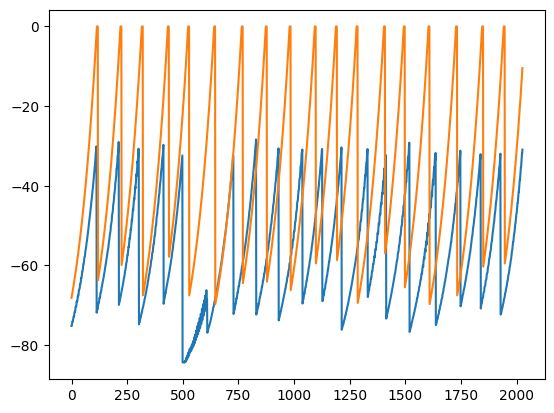

In [83]:
plt.plot(jlvalue)
plt.plot(mc_return[:length])

In [77]:
import numpy as np

gamma = 0.99

def compute_mc_return(reward, terminals, gamma=0.99):
    T = len(reward)
    returns = np.zeros_like(reward, dtype=np.float32)

    G = 0
    for t in reversed(range(T)):
        if terminals[t] == 1:
            G = 0                     # 에피소드 끝 → 리셋

        G = reward[t] + gamma * G
        returns[t] = G

    return returns

In [79]:
mc_return = compute_mc_return(dataset['rewards'], dataset['terminals'])

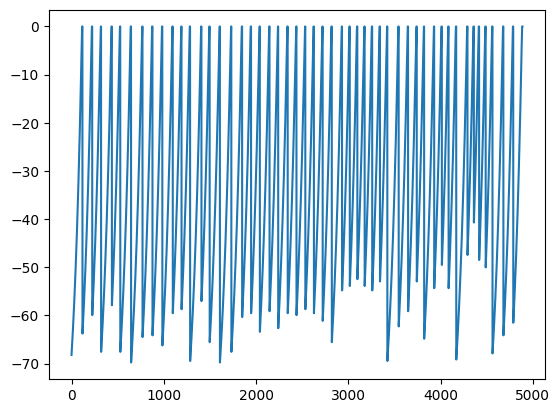

In [80]:
plt.plot(mc_return)

In [ ]:
import numpy as np
import imageio
from IPython.display import Video